# **Importing necessary libraries**

In [ ]:
# Importing necessary libraries
import numpy as np                                                              # For numerical operations and handling arrays
import pandas as pd                                                             # For data manipulation and analysis
import seaborn as sns                                                           # For statistical data visualization (e.g., heatmaps)
import matplotlib.pyplot as plt    
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

# **Reading Costumer Dataset**

In [ ]:
# Storing the path of the Excel file
path = 'Data/Online Retail.xlsx'
# Reading the Excel file
df = pd.read_excel(path)
# Displaying the data
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [52]:
# Ensure Total_Price column exists
df['Total_Price'] = df['Quantity'] * df['UnitPrice']

# Reference date for recency calculation
reference_date = df['InvoiceDate'].max()

# Group by CustomerID and calculate RFM metrics
df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                                     # Frequency
    'Total_Price': 'sum'                                      # Monetary
})

# Rename columns for clarity
df = df.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Total_Price': 'Monetary'
}).reset_index()

print(df.head())



   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          2      0.00
1     12347.0        1        182   4310.00
2     12348.0       74         31   1797.24
3     12349.0       18         73   1757.55
4     12350.0      309         17    334.40


In [53]:
# Assuming the RFM DataFrame has the features Recency, Frequency, Monetary
df_features = df[['Recency', 'Frequency', 'Monetary']]

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Apply the scaler to the RFM features
df_scaled = scaler.fit_transform(df_features)

# Create a new DataFrame for the scaled features
df_normalized = pd.DataFrame(df_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Combine the normalized features with the CustomerID
df_normalized = pd.concat([df[['CustomerID']].reset_index(drop=True), df_normalized], axis=1)

# Display the normalized RFM DataFrame
print(df_normalized.head())


   CustomerID   Recency  Frequency  Monetary
0     12346.0  0.871314   0.000125  0.015109
1     12347.0  0.002681   0.022676  0.030297
2     12348.0  0.198391   0.003758  0.021442
3     12349.0  0.048257   0.009020  0.021303
4     12350.0  0.828418   0.002005  0.016288


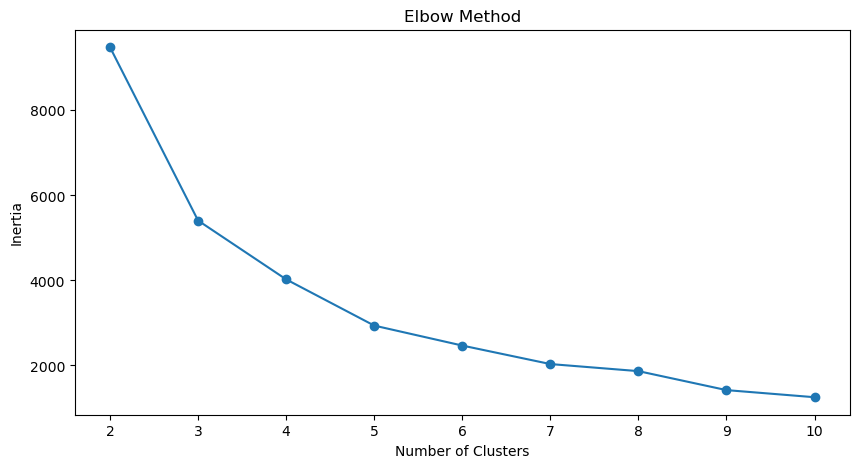

           CustomerID     Recency    Frequency       Monetary  DBSCAN_Cluster
Cluster                                                                      
0        15279.340393   39.027931   105.034377    1994.059792       -0.003990
1        15361.575703  245.567543    27.770626     464.787073       -0.000907
2        14918.833333    0.666667  4821.500000   55039.933333       -1.000000
3        15353.800000    8.000000  1013.400000  192103.854000       -1.000000


In [70]:
# Normalize RFM data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Recency', 'Frequency', 'Monetary']])

# Determine optimal clusters using Elbow Method
inertia = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)  # Sum of squared distances

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Fit K-Means with the optimal number of clusters
optimal_k = 4  # Example based on analysis (adjust based on your results)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Inspect clusters
print(df.groupby('Cluster').mean())


In [72]:
# Fit DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=5)  # Adjust eps and min_samples
dbscan_labels = dbscan.fit_predict(df_scaled)
# Inspect clusters
print(df.groupby('DBSCAN_Cluster').mean())


                  CustomerID    Recency    Frequency      Monetary   Cluster
DBSCAN_Cluster                                                              
-1              15103.440000  14.200000  1807.840000  78105.201600  1.120000
 0              15300.806303  91.489073    83.191396   1460.187664  0.253508


       TSNE1      TSNE2  KMeans_Cluster  DBSCAN_Cluster
0 -28.881769  71.976196               1               0
1  41.417255  -1.494684               0               0
2 -30.748764  -3.439742               0               0
3  12.259997 -31.176411               0               0
4 -36.721981  65.685806               1               0


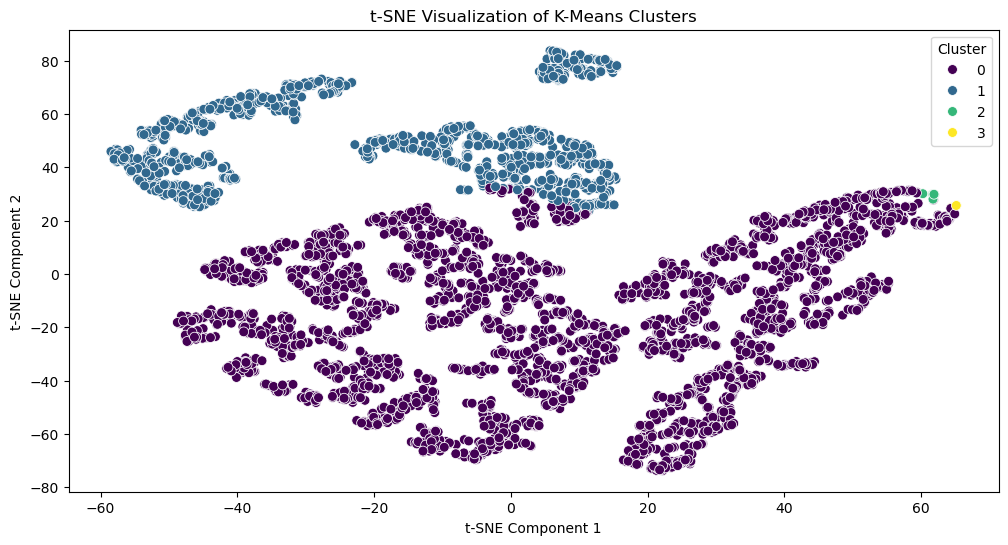

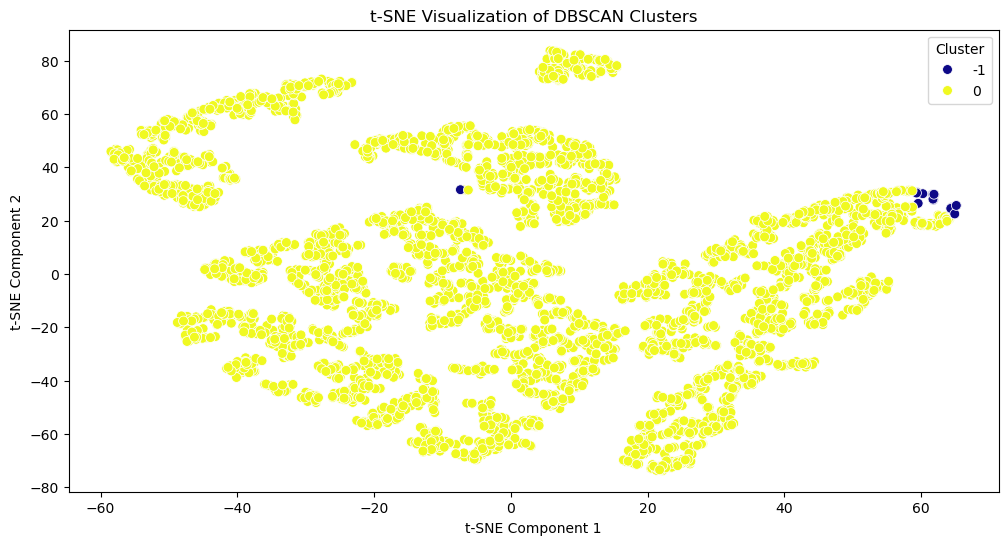

In [75]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)  # Adjust perplexity and iterations as needed
rfm_tsne = tsne.fit_transform(df_scaled)

# Convert to DataFrame for easier plotting
tsne_df = pd.DataFrame(rfm_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['KMeans_Cluster'] = df['Cluster']
tsne_df['DBSCAN_Cluster'] = df['DBSCAN_Cluster']
print(tsne_df.head())
# Plot K-Means Clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='TSNE1', 
    y='TSNE2', 
    hue='KMeans_Cluster', 
    palette='viridis', 
    data=tsne_df, 
    s=50
)
plt.title('t-SNE Visualization of K-Means Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

# Plot DBSCAN Clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='TSNE1', 
    y='TSNE2', 
    hue='DBSCAN_Cluster', 
    palette='plasma', 
    data=tsne_df, 
    s=50
)
plt.title('t-SNE Visualization of DBSCAN Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()